# Fetus Brain Detection

2024-05-26 11:40:44.030210: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 11:40:44.609127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2024-05-26 11:40:58.514987: I tensorflow/core/c

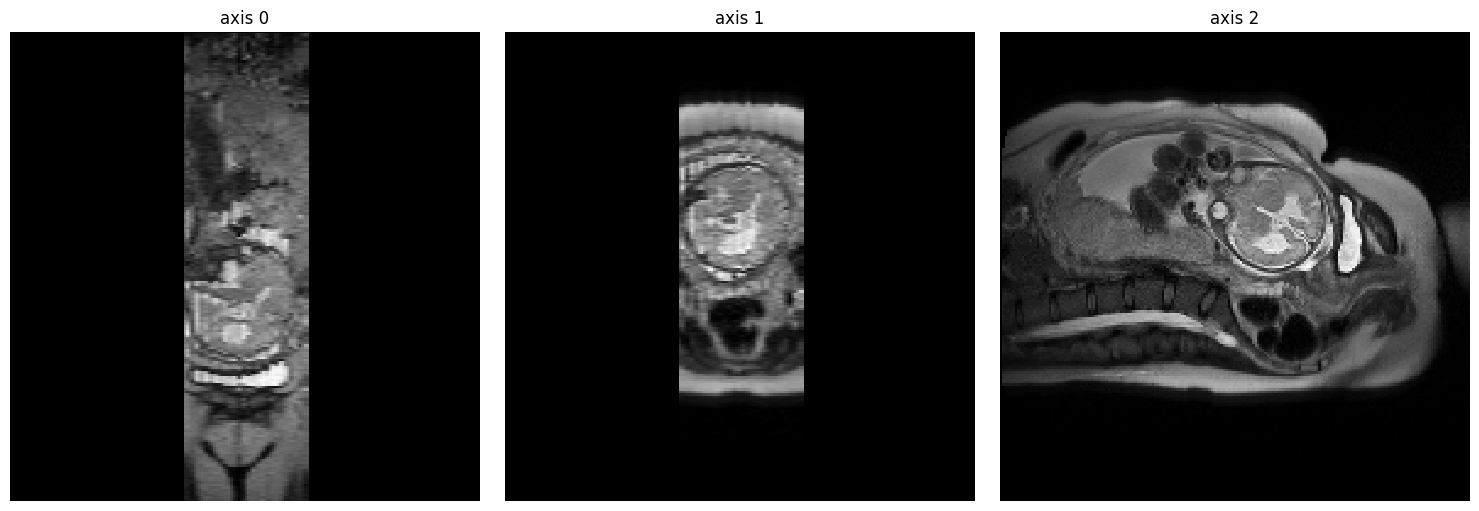

In [1]:
import tensorflow as tf
import numpy as np
from utils import *
import param_3d
import data
import model_3d
from data_3d import *

image_mask_pairs = load_validation_data("validation",192)
a, b = image_mask_pairs[0]

mean_slice_numbers = tuple(np.median(indices) for indices in np.where(b != 0))
ne.plot.volume3D(a,slice_nos=mean_slice_numbers);

Loading positive training db from generator...


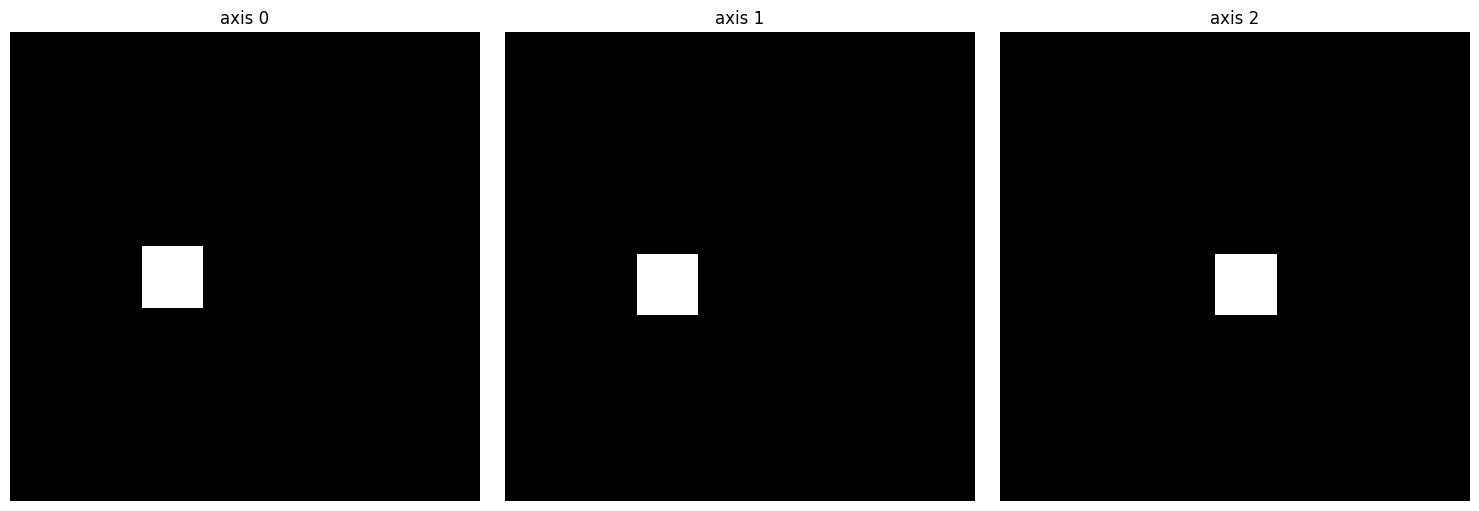

In [2]:
pos_db = load_db_detect_train_from_generator(a,b,192)
box = np.zeros((192, 192, 192), dtype=int)

# Set the specified region to 1
x1, y1, z1, x2, y2, z2 = pos_db[1][19]
box[x1:x2+1, y1:y2+1, z1:z2+1] = 1

mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(box,slice_nos=mean_slice_numbers)


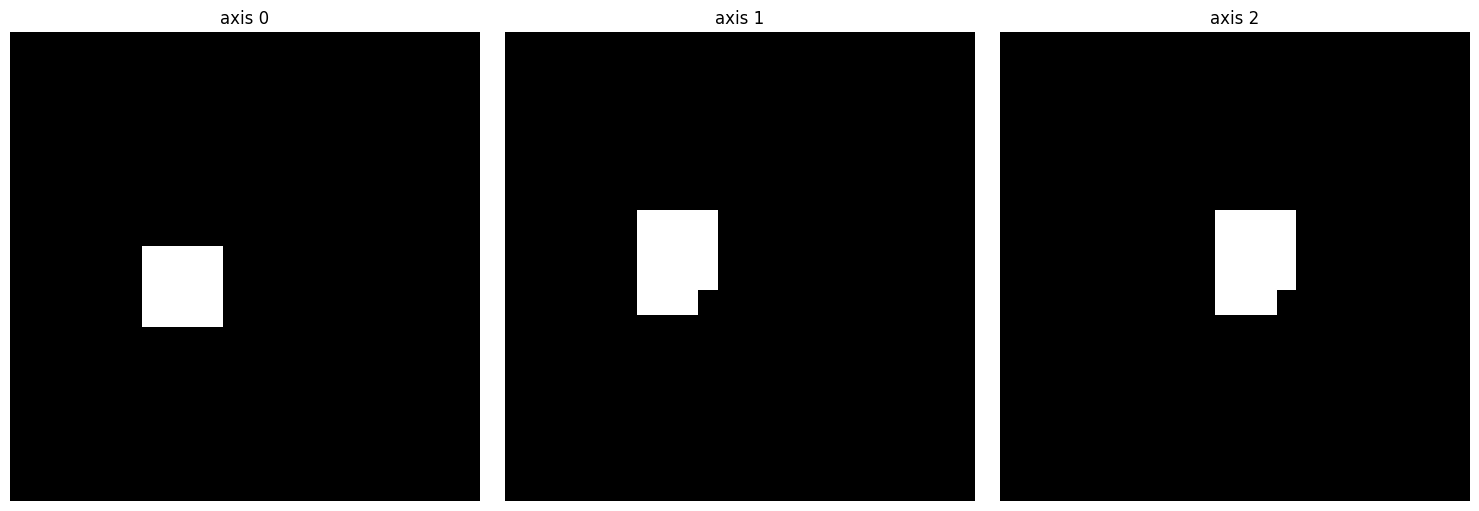

In [3]:
x1, y1, z1, x2, y2, z2 = pos_db[2][1]
box[x1:x2+1, y1:y2+1, z1:z2+1] = 1
mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(box,slice_nos=mean_slice_numbers)

In [4]:
x_db_calib=load_db_calib_train_from_generator([pos_db[0][19]],dim=12)

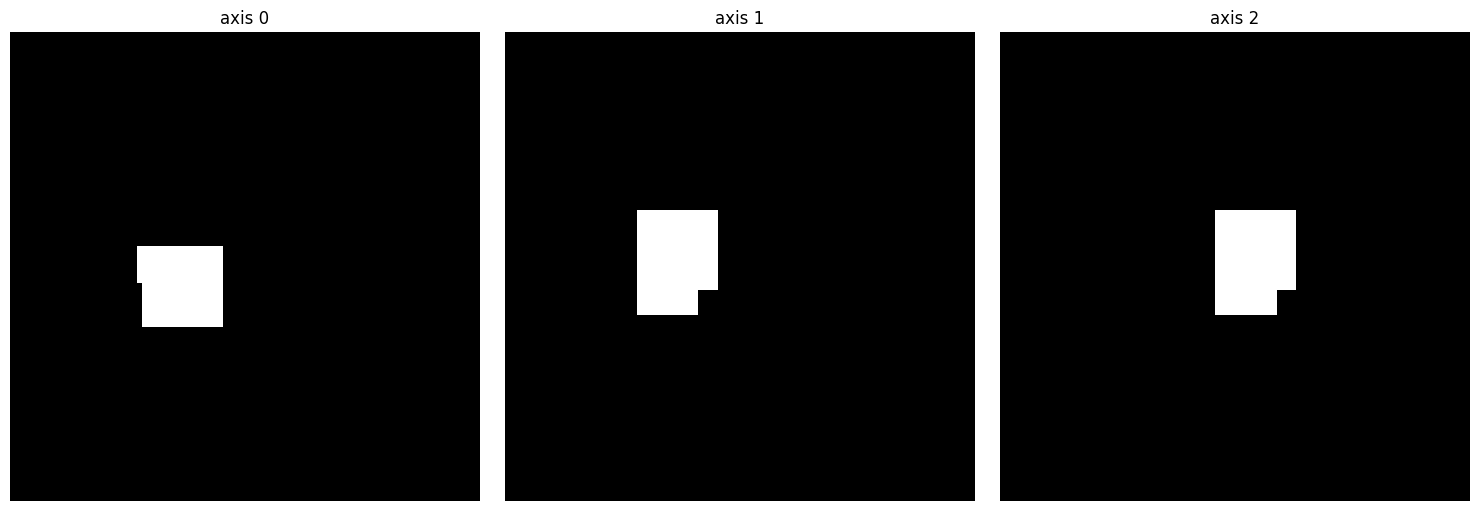

In [5]:
x1, y1, z1, x2, y2, z2 = x_db_calib[14]
box[x1:x2+1, y1:y2+1, z1:z2+1] = 1

mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(box,slice_nos=mean_slice_numbers)

# Generator

In [1]:
import pathlib
import json
import nibabel as nib
import numpy as np
import tensorflow as tf
from utils import *
import param_3d
import scipy.ndimage as ndimage

feta = pathlib.Path('feta_resized_192')
with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

feta_files = list(feta.glob('*.nii.gz'))
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]

feta_label_maps = [np.uint8(sf.load_volume(str(file_path)).resize(1.2).reshape([param_3d.img_size_6,]*3).data) for file_path in feta_files]
# feta_label_maps = [ndimage.gaussian_filter(img, sigma=(3, 3, 3), order=0) for img in feta_label_maps]
brain_maps = feta_label_maps
brain_maps = [tf.cast(brain, tf.uint8) for brain in brain_maps]

model_feta_config = config["feta_6"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_6"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_6, param_3d.img_size_6, param_3d.img_size_6]
model_feta_config["in_shape"]=[ param_3d.img_size_6, param_3d.img_size_6, param_3d.img_size_6]
model_shapes_config["in_shape"]=[ param_3d.img_size_6, param_3d.img_size_6, param_3d.img_size_6]

model_feta = create_model(model_feta_config)
model_shapes = create_model(model_shapes_config)


positions, indices = generate_position_map((192,192,192), param_3d.img_size_6, 4)
labels_to_image_model = create_model(model3_config)

gen=generator_brain_window_Net(brain_maps,param_3d.img_size_6)

2024-06-06 08:00:04.352010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2024-06-06 08:00:17.250299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(16, 16, 16, 3)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
Tensor("perlin_noise_1/strided_slice:0", shape=(4,), dtype=int32)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(16, 16, 16, 3)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
Tensor("perlin_noise_3/strided_slice:0", shape=(4,), dtype=int32)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)
(16, 16, 16, 3)
(None, 32, 32, 32, 1)
(None, 32, 32, 32, 1)


(16, 16, 16, 3)


2024-06-06 08:00:30.612391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(32, 32, 32, 2)
(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
(16, 16, 16, 3)
(1, 32, 32, 32, 1)


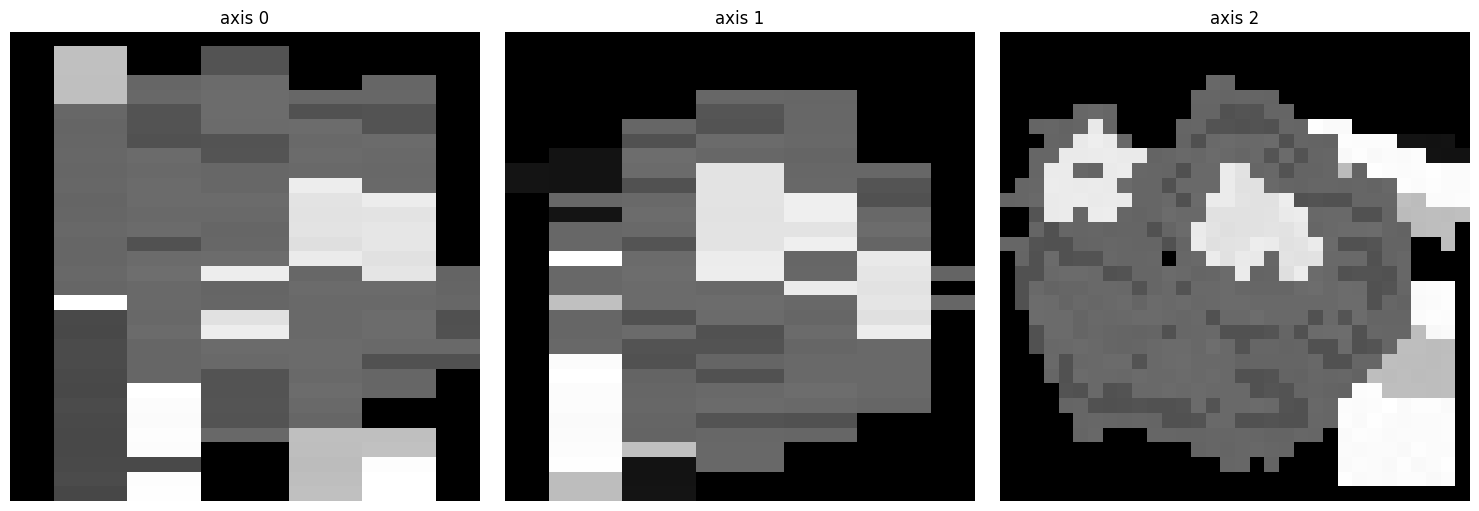

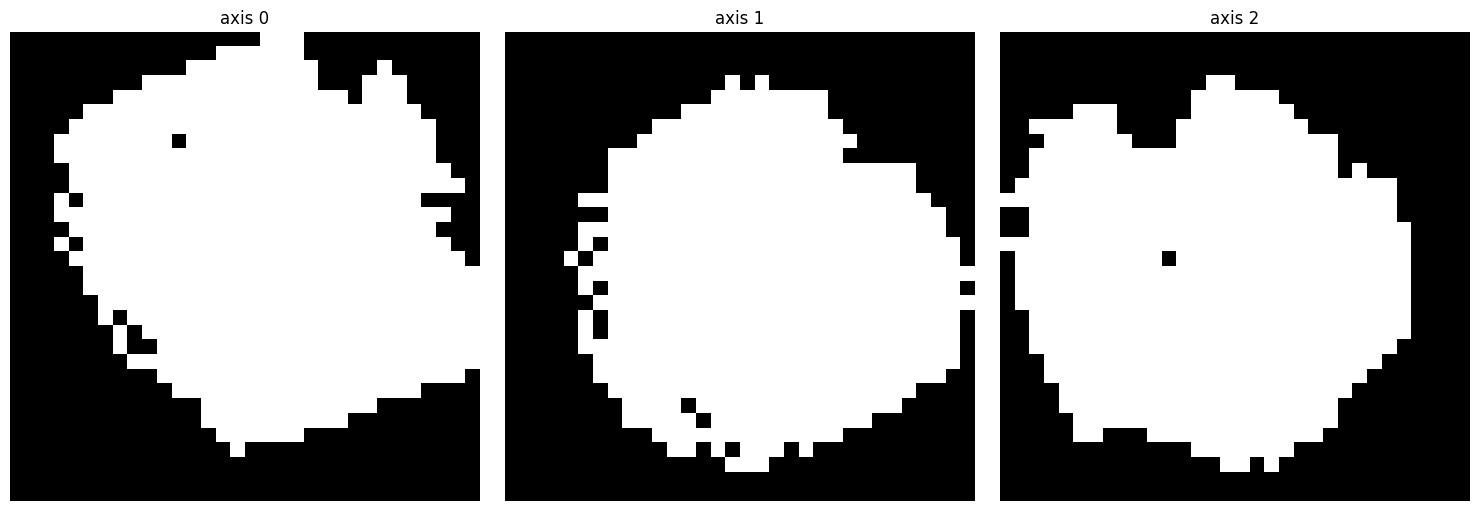

(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(32, 32, 32, 2)
(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
(16, 16, 16, 3)
(1, 32, 32, 32, 1)


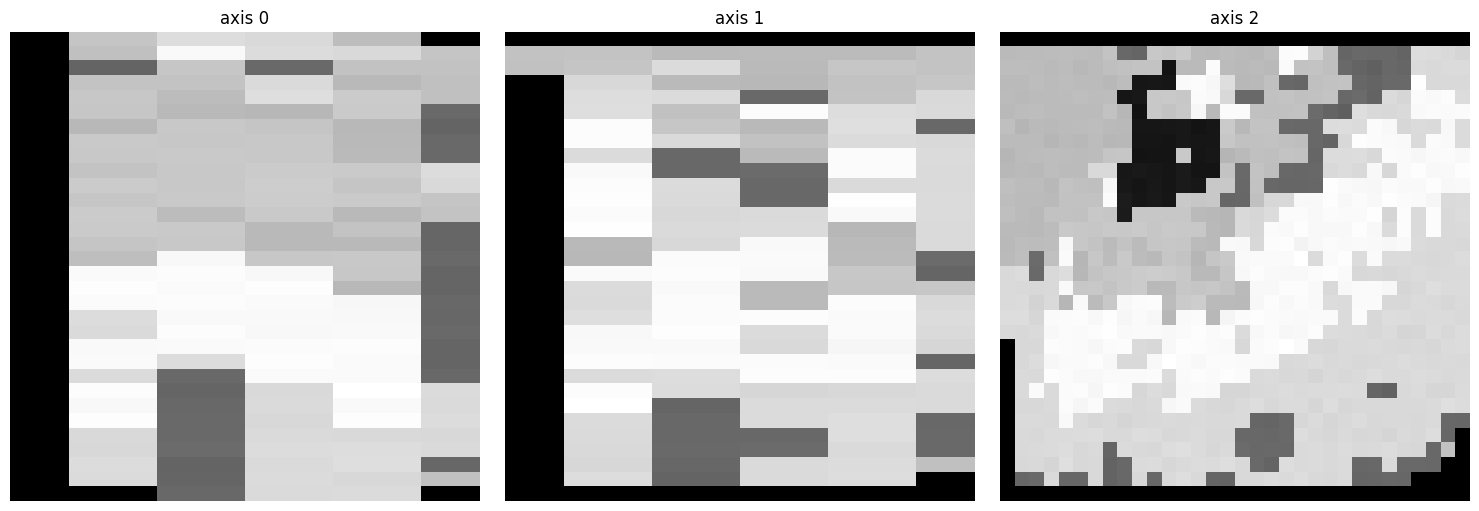

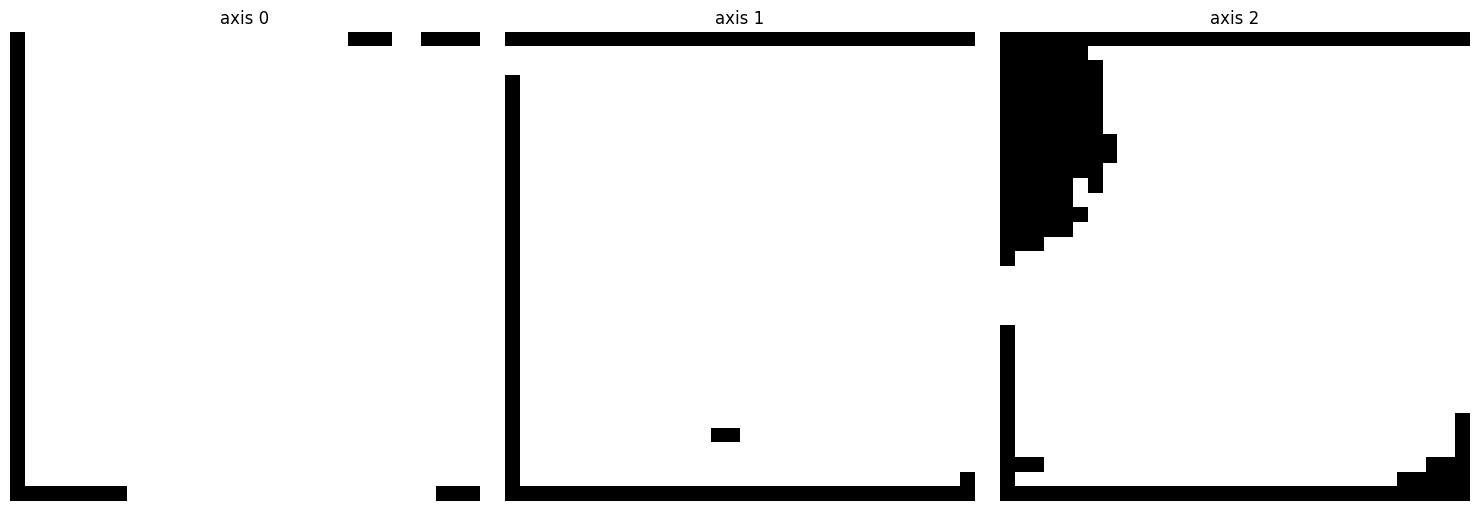

(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(32, 32, 32, 2)
(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
(16, 16, 16, 3)
(1, 32, 32, 32, 1)


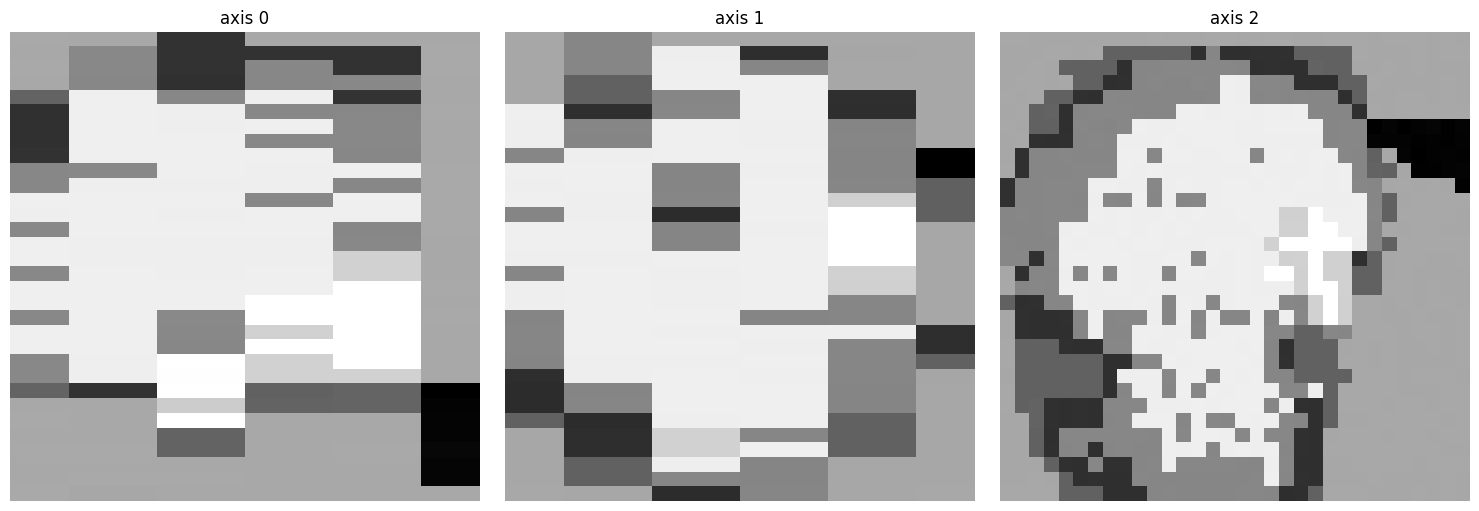

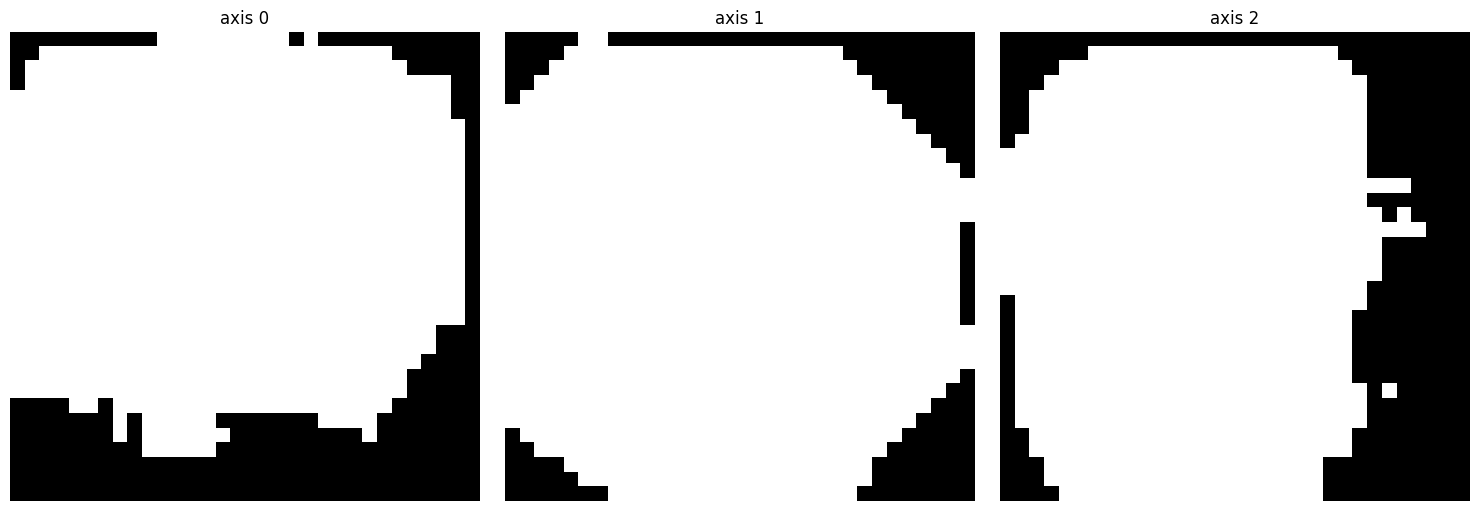

(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(32, 32, 32, 2)
(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
(16, 16, 16, 3)
(1, 32, 32, 32, 1)


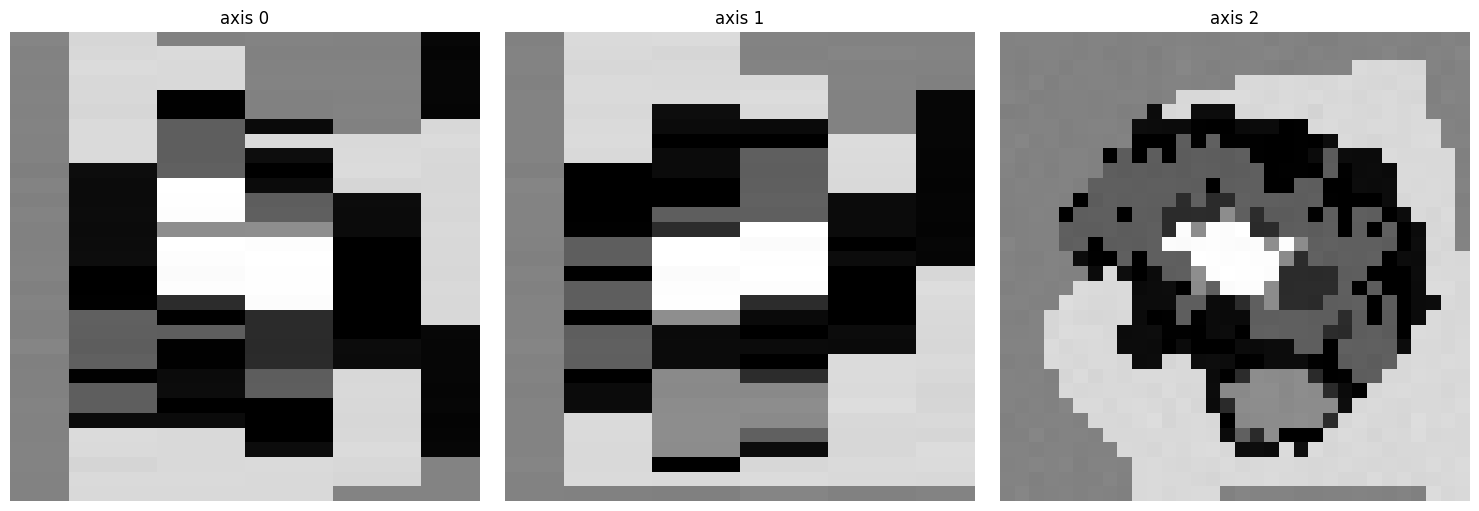

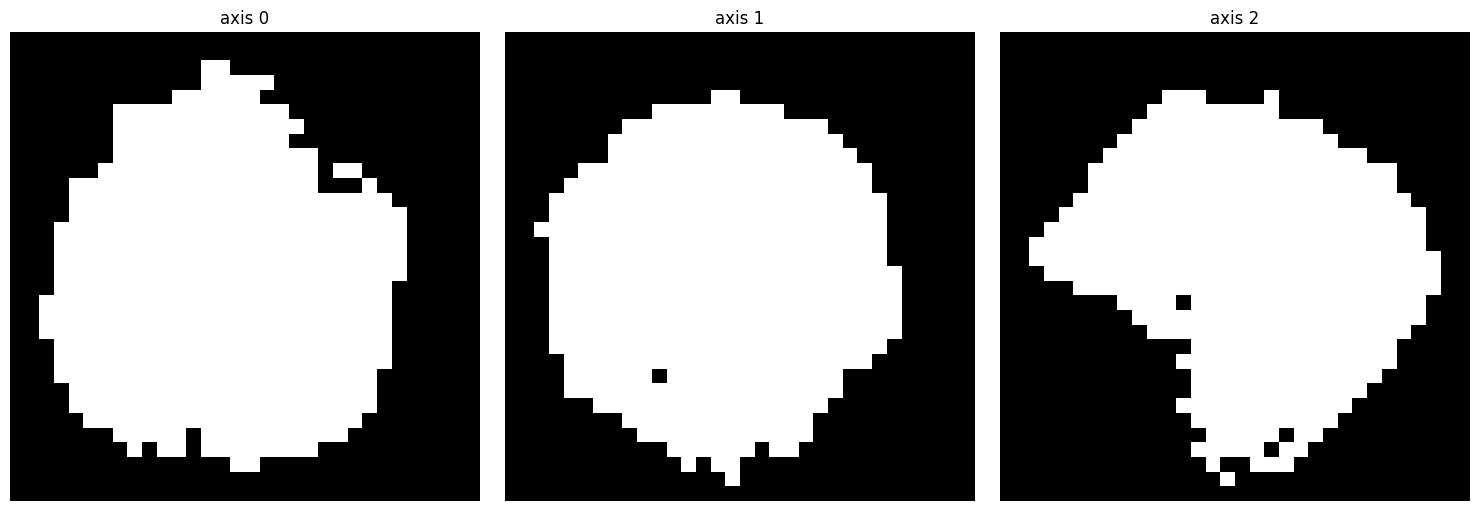

(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
fg [0 1 2 3 4 5 6 7]
(32, 32, 32, 2)
(16, 16, 16, 3)
tf.Tensor([32 32 32  1], shape=(4,), dtype=int32)
(16, 16, 16, 3)
(1, 32, 32, 32, 1)


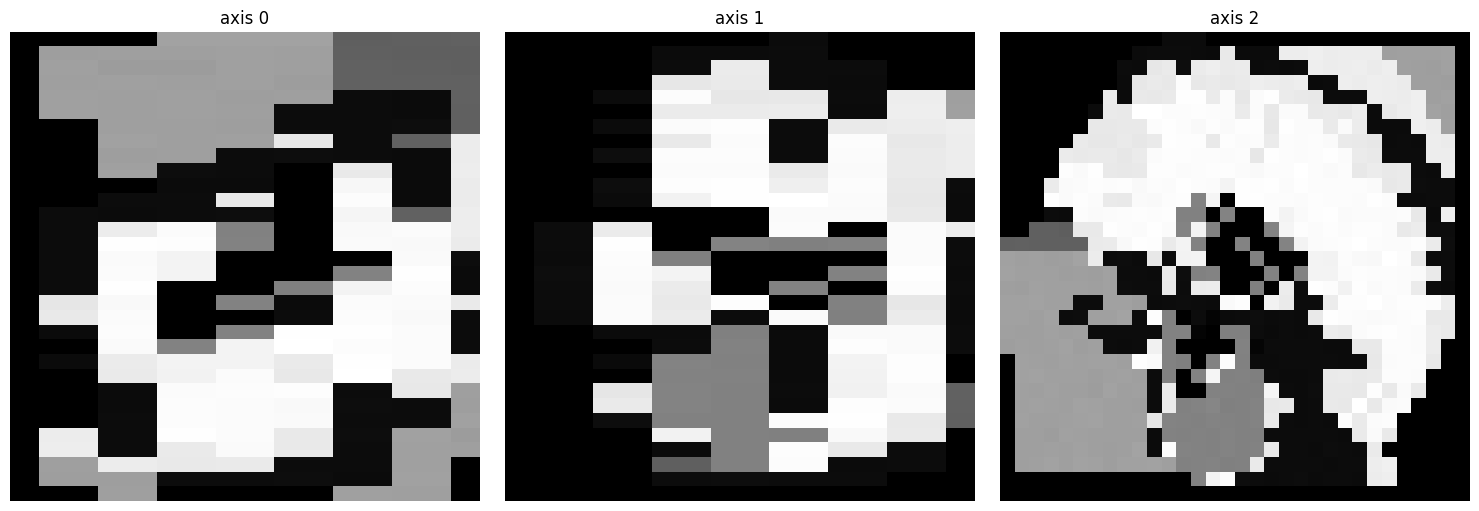

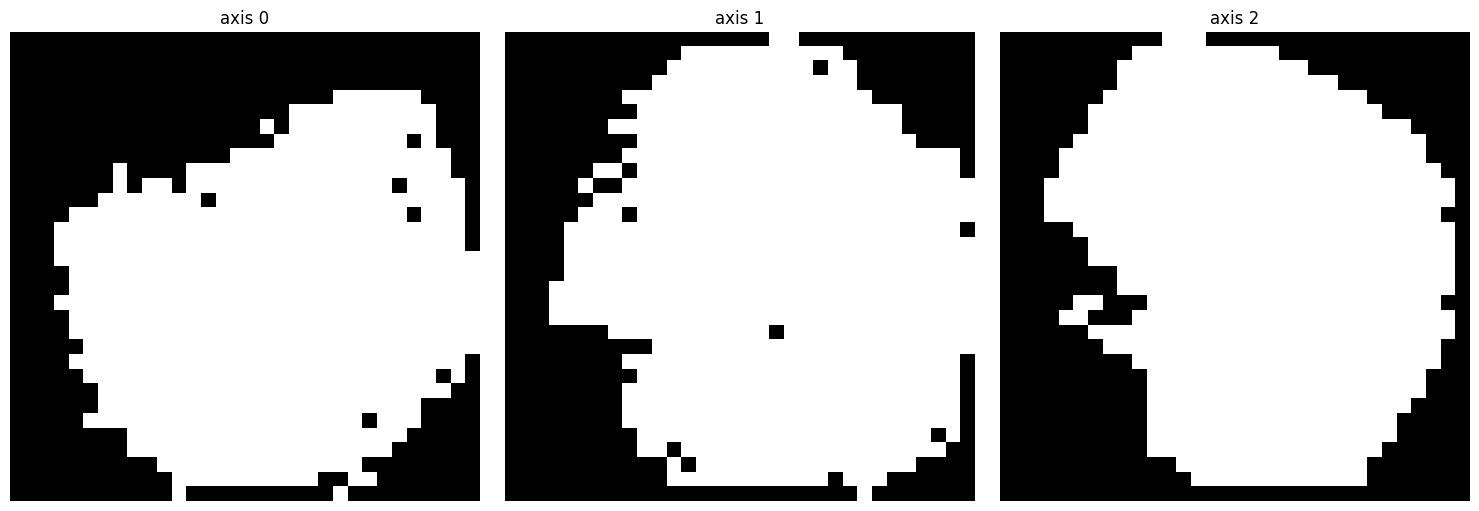

In [2]:
from scipy.ndimage import measurements
def shift_non_zero_elements(bg, shift_value):
    non_zero_mask = tf.not_equal(bg, 0)
    shifted_non_zero_elements = tf.where(non_zero_mask, bg + shift_value, bg)
    return shifted_non_zero_elements
    
j=0
for i in range(9000):
    fragment = next(gen)
    # ne.plot.volume3D(fragment,cmaps=['tab20c'],slice_nos=ms);

    _, fg = model_feta(fragment)

    print("fg",np.unique(fg))
    

    # ms = tuple(map(int, measurements.center_of_mass(np.isin(fragment, [1, 2, 3, 4, 5, 6, 7]))))
    

    shapes = draw_shapes_easy(shape = (param_3d.img_size_6,)*3)    
    # shapes = draw_shapes(shape = (param_3d.img_size_6,)*3)

    shapes = tf.squeeze(shapes)
    shapes = tf.cast(shapes, tf.uint8)
    
    _, bg = model_shapes(shapes[None,...,None])
    bg = bg+shift_non_zero_elements(bg,8)    
    result = fg + bg * tf.cast(fg == 0,tf.int32)

    # a = tf.random.uniform([], minval=0, maxval=2, dtype=tf.int32)
    # result = tf.cond(tf.equal(a, 0), lambda: tf.identity(bg), lambda: tf.identity(result))


    generated_img, y = labels_to_image_model(result)

    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    

    # if tf.abs(ms)>32:
        # ms=(12,12,12)
    ne.plot.volume3D(generated_img)#,slice_nos=ms);
    ne.plot.volume3D(np.argmax(y,axis=-1))#,slice_nos=ms);

    j=j+1
    if j==5:
        break